# Build a Retrieval Augmented Generation (RAG) App: Part 1
- 출처 : https://colab.research.google.com/github/langchain-ai/langchain/blob/master/docs/docs/tutorials/rag.ipynb
- 수정사항 : 설명 한글화 및 간소화

In [1]:
%pip install --quiet --upgrade langchain langchain_openai langchain-text-splitters langchain-community langgraph

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
import os
import getpass

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

In [34]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [5]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

In [6]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

## Preview

이 가이드에서는 웹사이트 콘텐츠에 대한 질문에 답하는 앱을 빌드합니다.   
사용할 특정 웹사이트는 Lilian Weng의  [LLM Powered Autonomous Agents](https://lilianweng.github.io/posts/2023-06-23-agent/)  블로그 게시물로,  
 게시물 콘텐츠에 대한 질문을 할 수 있습니다.

약 50줄의 코드로 이를 수행하기 위한 간단한 인덱싱 파이프라인과 RAG 체인을 만들 수 있습니다.

## 1. Indexing

### Loading documents

DocumentLoader로 블로그 게시물 콘텐츠를 로드 합니다.   
이는 소스에서 데이터를 로드하고
[Document](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.base.Document.html)
객체 목록을 반환하는 객체입니다.

[WebBaseLoader](/docs/integrations/document_loaders/web_base)를 사용하겠습니다.   

`urllib`를 사용하여 웹 URL에서 HTML을 로드하고 `BeautifulSoup`를 사용하여 텍스트로 구문 분석합니다.    
`bs_kwargs`를 통해 `BeautifulSoup` 파서에 매개변수를 전달하여 HTML -\> 텍스트 파싱을 사용자 정의할 수 있습니다([BeautifulSoup
docs](https://beautiful-soup-4.readthedocs.io/en/latest/#beautifulsoup) 참조).  
이 경우 클래스 "post-content", "post-title" 또는
"post-header"가 있는 HTML 태그만 관련이 있으므로 다른 모든 태그를 제거합니다.

In [7]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 43130


In [8]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


#### 더 자세히 알아보기

`DocumentLoader`: 소스에서 데이터를 `Documents` list 로드하는 객체 .

### Splitting documents
로드된 문서는 42,000자를 넘으며 많은 모델의 컨텍스트 창에 맞추기에는 너무 깁니다.    
컨텍스트 창에 전체 게시물을 맞출 수 있는 모델의 경우에도 모델은 매우 긴 입력에서 정보를 찾는 데 어려움을 겪을 수 있습니다.  
이를 처리하기 위해 문서를 임베딩 및 벡터 저장을 위한 청크로 분할합니다.   
이렇게 하면 런타임에 블로그 게시물에서 가장 관련성 있는 부분만 검색하는 데 도움이 됩니다.

RecursiveCharacterTextSplitte는 각 청크가 적절한 크기가 될 때까지 줄바꿈과 같은 일반적인 구분 기호를 사용하여 문서를 재귀적으로 분할합니다.


In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


#### 더 자세히 알아보기

`TextSplitter`: `Document` list를 더 작은 청크로 분할하는 객체입니다.   `DocumentTransformer`의 하위 클래스입니다.  
`DocumentTransformer`: Document 객체 목록에서 변환을 수행하는 객체.


### Storing documents
텍스트 청크를 인덱싱하여 런타임에 검색할 수 있도록 합니다.   
각 문서 분할의 내용을 임베드하고 이러한 임베딩을 벡터 저장소에 저장합니다.  
입력 쿼리가 주어지면 벡터 검색을 사용하여 관련 문서를 검색할 수 있습니다.

In [12]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['74f6149a-8211-4ee1-beaa-14d9eaea8f31', 'bdc520bb-c9c8-4182-b41c-98deea05e31c', 'fdcd673a-2966-4bed-80e5-06b4b20d1b10']


#### 더 자세히 알아보기

`Embeddings`: 텍스트 임베딩 모델을 감싸는 래퍼로, 텍스트를 임베딩으로 변환하는 데 사용됩니다.

`VectorStore`: 벡터 데이터베이스를 감싸는 래퍼로, 임베딩을 저장하고
쿼리하는 데 사용됩니다.


파이프라인의 **인덱싱** 부분이 완료되었습니다. 이 시점에서
블로그 게시물의 청크된 콘텐츠를 포함하는 쿼리 가능한 벡터 저장소가 있습니다.
사용자 질문이 주어지면 이상적으로는
질문에 답하는 블로그 게시물의 스니펫을 반환할 수 있어야 합니다.

## 2. Retrieval and Generation



In [13]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


[LangGraph](https://langchain-ai.github.io/langgraph/)를 사용하여 검색 및 생성 단계를 단일 애플리케이션으로 연결합니다. 이렇게 하면 여러 가지 이점이 있습니다.

- 애플리케이션 로직을 한 번 정의하면 스트리밍, 비동기 및 일괄 호출을 포함한 여러 호출 모드를 자동으로 지원할 수 있습니다.
- [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/)을 통해 간소화된 배포를 얻습니다.
- LangSmith가 애플리케이션의 단계를 자동으로 추적합니다.
- 최소한의 코드 변경으로 [persistence](https://langchain-ai.github.io/langgraph/concepts/persistence/) 및 [human-in-the-loop approval](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/)을 포함한 주요 기능을 애플리케이션에 쉽게 추가할 수 있습니다.

LangGraph를 사용하려면 세 가지를 정의해야 합니다.

1. 애플리케이션의 상태;
2. 애플리케이션의 노드(i.e., application steps);
3. 애플리케이션의 "제어 흐름"(e.g., the ordering of the steps).

#### State:

애플리케이션의 [state](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)는 애플리케이션에 입력되는 데이터, 단계 간에 전송되는 데이터, 애플리케이션에서 출력되는 데이터를 제어합니다.   
일반적으로 `TypedDict`이지만 [Pydantic BaseModel](https://langchain-ai.github.io/langgraph/how-tos/state-model/)일 수도 있습니다.

간단한 RAG 애플리케이션의 경우 입력 질문, 검색된 컨텍스트, 생성된 답변을 추적할 수 있습니다.

In [14]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

#### Nodes (application steps)

두 단계로 이루어진 간단한 순서로 시작해 보겠습니다. : retrieval and generation.

In [15]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

검색 단계(retrieval step)는 입력 질문을 사용하여 유사성 검색을 실행하고, 생성 단계는 검색된 컨텍스트와 원래 질문을 채팅 모델의 프롬프트로 포맷합니다.

#### 제어 흐름

마지막으로, 애플리케이션을 단일 그래프 객체로 컴파일합니다. 이 경우 검색 및 생성 단계를 단일 시퀀스로 연결합니다.

In [16]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

LangGraph에는 애플리케이션의 제어 흐름을 시각화하기 위한 기본 제공 유틸리티도 함께 제공됩니다.

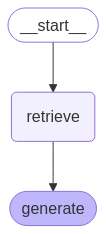

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

<details>
<summary>LangGraph를 사용해야 합니까?</summary>

LangGraph는 RAG 애플리케이션을 빌드하는 데 필요하지 않습니다. 실제로 개별 구성 요소를 호출하여 동일한 애플리케이션 로직을 구현할 수 있습니다.:

```python
question = "..."

retrieved_docs = vector_store.similarity_search(question)
docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)
prompt = prompt.invoke({"question": question, "context": docs_content})
answer = llm.invoke(prompt)
```

LangGraph의 이점은 다음과 같습니다.

- 다중 호출 모드 지원: 출력 토큰을 스트리밍하거나 개별 단계의 결과를 스트리밍하려는 경우 이 논리를 다시 작성해야 합니다.
- [LangSmith](https://docs.smith.langchain.com/)를 통한 추적 및 [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/)을 통한 배포에 대한 자동 지원
- 지속성, 인간 참여 및 기타 기능 지원.

많은 사용 사례에서 대화형 경험에서 RAG가 필요하므로 사용자는 상태 기반 대화를 통해 상황에 맞는 답변을 받을 수 있습니다. LangGraph의 상태 관리 및 지속성은 이러한 애플리케이션을 엄청나게 단순화합니다

</details>

#### 사용법

애플리케이션을 테스트해 봅시다! LangGraph는 동기, 비동기, 스트리밍을 포함한 여러 호출 모드를 지원합니다.

Invoke:

In [ ]:
result = graph.invoke({"question": "Task Decomposition 이 뭐야? 한글로 설명해줘"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='e90bffdc-ea53-44f6-bd79-334051db16b8', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='fdcd673a-2966-4bed-80e5-06b4b20d1b10', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous age

Stream 스텝:

In [22]:
for step in graph.stream(
    {"question": "Task Decomposition 이 뭐야? 한글로 설명해줘"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='e90bffdc-ea53-44f6-bd79-334051db16b8', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='fdcd673a-2966-4bed-80e5-06b4b20d1b10', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powere

토큰 스트리밍:

In [23]:
for message, metadata in graph.stream(
    {"question": "Task Decomposition 이 뭐야? 한글로 설명해줘"}, stream_mode="messages"
):
    print(message.content, end="|")

|Task| De|composition|은| 복|잡|한| 작업|을| 더| 작|고| 단|순|한| 단계|로| 나|누|는| 과정|입니다|.| 이를| 통해| 각| 단계|에서| "|사|고|하며|"| 작업|을| 수행|할| 수| 있도록| 모델|에게| 지|침|을| 주|는| 방법|입니다|.| 예|를| 들어|,| 특정| 목표|를| 달|성|하기| 위한| 하|위| 목표|를| 정의|하거나| 작업|을| 수행|하는| 단계|들을| 나|열|하는| 것이| 포함|됩니다|.||

In [24]:
from langchain_core.prompts import PromptTemplate

template = """다음 맥락을 사용하여 마지막 질문에 답하세요.
답을 모른다면 모른다고만 말하고, 답을 만들어내려고 하지 마세요.
최대 3문장을 사용하고 가능한 한 간결하게 답하세요.
답변 끝에는 항상 "질문해 주셔서 감사합니다!"라고 말하세요.

{context}

질문: {question}

도움이 되는 답변:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [25]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

벡터 스토어의 문서를 업데이트해야 합니다.   
이를 위해 간단한 [InMemoryVectorStore](https://python.langchain.com/api_reference/core/vectorstores/langchain_core.vectorstores.in_memory.InMemoryVectorStore.html)를 사용합니다.   
특정 기능 중 일부(예: 메타데이터 필터링)를 사용합니다.

In [26]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

다음으로 검색 쿼리에 대한 스키마를 정의해 보겠습니다.  
이 목적을 위해 구조화된 출력을 사용합니다.  
여기서는 문자열 쿼리와 문서 섹션("beginning", "middle", "end")을 포함하는 쿼리를 정의하지만, 원하는 대로 정의할 수 있습니다.

In [27]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

마지막으로, 사용자의 원시 입력에서 쿼리를 생성하는 단계를 LangGraph 애플리케이션에 추가합니다.

In [28]:
class State(TypedDict):
    question: str
    # highlight-next-line
    query: Search
    context: List[Document]
    answer: str


# highlight-next-line
def analyze_query(state: State):
    # highlight-next-line
    structured_llm = llm.with_structured_output(Search)
    # highlight-next-line
    query = structured_llm.invoke(state["question"])
    # highlight-next-line
    return {"query": query}


def retrieve(state: State):
    # highlight-start
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    # highlight-end
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# highlight-start
graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
# highlight-end
graph = graph_builder.compile()

<details>
<summary>Full Code:</summary>

```python
from typing import Literal

import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import Annotated, List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)


# Update metadata (illustration purposes)
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


# Index chunks
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)


# Define schema for search
class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()
```

</details>

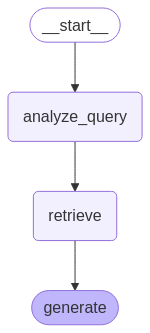

In [29]:
display(Image(graph.get_graph().draw_mermaid_png()))

우리는 게시물 끝에서 맥락을 구체적으로 요청하여 구현을 테스트할 수 있습니다. 모델이 답변에 다른 정보를 포함한다는 점에 유의하세요.

In [31]:
for step in graph.stream(
    {"question": "게시물의 끝 부분에서는 Task Decomposition에 대해 무엇이라고 말합니까?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='2a562c90-8b8d-4de0-ba8d-094f2bc94212', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 39220, 'section': 'end'}, page_content='Finite context length: The restricted context capacity limits the inclusion of historical information, detailed instructions, API call context, and responses. The design of the system has to work with this limited communication bandwidth, while mechanisms like self-reflection to learn from past mistakes would benefit a lot from long or infinite context windows. Although vector stores and retrieval can provide access to a larger knowledge pool, their representation power is not as powerful as full attention.\n\n\nChallenges in long-term planning and task decomposition: Planning over a lengthy history and effectively exploring the solution space remain challenging. LLMs struggle to adj

스트리밍 단계와 [LangSmith 추적](https://smith.langchain.com/) 모두에서 이제 검색 단계에 입력된 구조화된 쿼리를 관찰할 수 있습니다.